In [1]:
from matplotlib import pyplot as plt
import numpy as np
import yaml
import torch
from os.path import join

import sys
sys.path.append('/home/leiyu/projects/def-yangxu/leiyu/circuit-discovery')

mask_dir = '/home/leiyu/scratch/circuit-discovery/mask_logits/'

In [2]:
from pathlib import Path
from matplotlib import pyplot as plt
import yaml

import torch
import numpy as np
from graphviz import Digraph


def no_revisit(func):
    def wrapper(self, *args, **kwargs):
        if not self.visited:
            func(self, *args, **kwargs)
            self.visited = True
    return wrapper

class Node:
    def __init__(self, name):
        self.name = name
        self.children = []
        self.parents = []

        self.visited = False

    def __call__(self):
        if self.name == 'input':
            return ('input',)
        elif self.name == 'output':
            return ('output',)
        elif self.name.startswith('attn'):
            t, i, j = self.name.split('_')
            i, j = int(i), int(j)
            return t, i, j
        elif self.name.startswith('mlp'):
            t, i = self.name.split('_')
            i = int(i)
            return t, i


    @property
    def color(self):
        if self.name == 'input':
            return 'blue'
        elif self.name == 'output':
            return 'blue'
        elif self.name.startswith('attn'):
            return 'red'
        elif self.name.startswith('mlp'):
            return 'green'
        else:
            raise ValueError

    def add_child(self, child):
        self.children.append(child)
        child.parents.append(self)

    def __repr__(self):
        return f'[{self.name}]'



    # @no_revisit
    def dfs_connections(self):
        conns = set()
        for child in self.children:
            # conns.add((self.name, child.name))
            conns.add((child.name, self.name))
            conns = conns.union(child.dfs_connections())
        return conns

    # @no_revisit
    def dfs_connections_r(self):
        conns = set()
        for parent in self.parents:
            # conns.add((parent.name, self.name))
            conns.add((self.name, parent.name))
            conns = conns.union(parent.dfs_connections_r())
        return conns



class GPTGraph:
    def __init__(self):
        nodes = {
            'input': Node('input'),
            'output': Node('output'),
        }
        for i in range(12):
            for j in range(12):
                nodes[f'attn_{i}_{j}_Q'] = Node(f'attn_{i}_{j}_Q')
                nodes[f'attn_{i}_{j}_K'] = Node(f'attn_{i}_{j}_K')
                nodes[f'attn_{i}_{j}_V'] = Node(f'attn_{i}_{j}_V')
                nodes[f'attn_{i}_{j}_O'] = Node(f'attn_{i}_{j}_O')
            nodes[f'mlp_{i}'] = Node(f'mlp_{i}')
        self.nodes = nodes
        self.input_node = self.nodes['input']
        self.output_node = self.nodes['output']
        self.attn = lambda i,j,M: self.nodes[f'attn_{i}_{j}_{M}']
        self.mlp = lambda i: self.nodes[f'mlp_{i}']

    def reset_graph(self):
        for node in self.nodes.values():
            node.visited = False

    def set_connections(self, masks):
        output_mask, attn_Q_masks, attn_K_masks, attn_V_masks, edge_mask_mlp = masks

        for i in range(12):
            output_mask_i = output_mask[1:][i*13:(1+i)*13]
            mlp_i_output_edge = output_mask_i[-1]
            if mlp_i_output_edge == 1:
                self.output_node.add_child(self.mlp(i))

            for j in range(12):
                attn_ij_output_edge = output_mask_i[j]
                if attn_ij_output_edge == 1:
                    self.output_node.add_child(self.attn(i,j,'O'))

        for i in range(12):
            edge_mask_mlps_i = edge_mask_mlp[i]
            if edge_mask_mlps_i[0] == 1:
                self.mlp(i).add_child(self.input_node)
            for j in range(i+1):
                edge_mask_mlps_ij = edge_mask_mlps_i[1:][j*13:(1+j)*13]
                if j < i:
                    edge_mask_mlps_i_mlp_j = edge_mask_mlps_ij[-1]
                    if edge_mask_mlps_i_mlp_j == 1:
                        self.mlp(i).add_child(self.mlp(j))
                for k in range(12):
                    edge_mask_mlps_i_attn_jk = edge_mask_mlps_ij[k]
                    if edge_mask_mlps_i_attn_jk == 1:
                        self.mlp(i).add_child(self.attn(j,k,'O'))

        for i in range(12):
            for j in range(12):
                self.attn(i,j,'O').add_child(self.attn(i,j,'Q'))
                self.attn(i,j,'O').add_child(self.attn(i,j,'K'))
                self.attn(i,j,'O').add_child(self.attn(i,j,'V'))
                
                edge_mask_attn_ij_Q = attn_Q_masks[i][:, j]
                edge_mask_attn_ij_K = attn_K_masks[i][:, j]
                edge_mask_attn_ij_V = attn_V_masks[i][:, j]
                
                if edge_mask_attn_ij_Q[0] == 1:
                    self.attn(i,j,'Q').add_child(self.input_node)
                if edge_mask_attn_ij_K[0] == 1:
                    self.attn(i,j,'K').add_child(self.input_node)
                if edge_mask_attn_ij_V[0] == 1:
                    self.attn(i,j,'V').add_child(self.input_node)
                    
                for k in range(i):
                    edge_mask_attn_ij_k_Q = edge_mask_attn_ij_Q[1:][k*13:(1+k)*13]
                    edge_mask_attn_ij_k_K = edge_mask_attn_ij_K[1:][k*13:(1+k)*13]
                    edge_mask_attn_ij_k_V = edge_mask_attn_ij_V[1:][k*13:(1+k)*13]

                    if edge_mask_attn_ij_k_Q[-1] == 1:
                        self.attn(i,j,'Q').add_child(self.mlp(k))
                    if edge_mask_attn_ij_k_K[-1] == 1:
                        self.attn(i,j,'K').add_child(self.mlp(k))
                    if edge_mask_attn_ij_k_V[-1] == 1:
                        self.attn(i,j,'V').add_child(self.mlp(k))
                        
                    for l in range(12):
                        if edge_mask_attn_ij_k_Q[l] == 1:
                            self.attn(i,j,'Q').add_child(self.attn(k,l,'O'))
                        if edge_mask_attn_ij_k_K[l] == 1:
                            self.attn(i,j,'K').add_child(self.attn(k,l,'O'))
                        if edge_mask_attn_ij_k_V[l] == 1:
                            self.attn(i,j,'V').add_child(self.attn(k,l,'O'))
            

    
    def render_plot(self, fig_name, mode='both'):
        
        edges, nodes = self.get_connections(mode)
        graph = Digraph()
        
        for node in nodes:
            graph.node(node.name, color=node.color)
            
        graph.edges(edges)
        
        graph.render(fig_name)


    def get_connections(self, mode='both'):

        if mode == 'dfs':
            conns = self.output_node.dfs_connections()
        elif mode == 'dfs_r':
            conns = self.input_node.dfs_connections_r()
        elif mode == 'both':
            conns = self.output_node.dfs_connections()
            conns_r = self.input_node.dfs_connections_r()
            conns = conns.intersection(conns_r)
        elif mode == 'all':
            conns = set()
            for node in self.nodes.values():
                for child in node.children:
                    conns.add((child.name, node.name))
                    # conns.add((node.name, child.name))
        nodes = []
        for e in conns:
            nodes.append(self.nodes[e[0]])
            nodes.append(self.nodes[e[1]])
        return conns, set(nodes)


In [16]:
mask_logits_dict_edge = torch.load(
    join(mask_dir, f'mask_logits_dict_edge_oqa_weight_114_edge_35.pt')
)

mask_logits_dict_edge = {k:v.detach().cpu() for k,v in mask_logits_dict_edge.items()}
torch.cuda.empty_cache()

output_mask = torch.where(mask_logits_dict_edge['edge_mask_output_logits'] > 0., 1., 0.)
attn_q_masks, attn_k_masks, attn_v_masks = [], [], []
mlp_masks = []

for i in range(12):
    attn_q_masks_logits_i = mask_logits_dict_edge[f'blocks.{i}.edge_mask_attention_q_logits']
    attn_k_masks_logits_i = mask_logits_dict_edge[f'blocks.{i}.edge_mask_attention_k_logits']
    attn_v_masks_logits_i = mask_logits_dict_edge[f'blocks.{i}.edge_mask_attention_v_logits']
    mlp_masks_logits_i = mask_logits_dict_edge[f'blocks.{i}.edge_mask_mlp_logits']

    attn_q_masks.append(torch.where(attn_q_masks_logits_i > 0., 1., 0.))
    attn_k_masks.append(torch.where(attn_k_masks_logits_i > 0., 1., 0.))
    attn_v_masks.append(torch.where(attn_v_masks_logits_i > 0., 1., 0.))
    mlp_masks.append(torch.where(mlp_masks_logits_i > 0., 1., 0.))

masks = (output_mask, attn_q_masks, attn_k_masks, attn_v_masks, mlp_masks)
gpt_graph = GPTGraph()
gpt_graph.set_connections(masks)


In [17]:
masks = (output_mask, attn_q_masks, attn_k_masks, attn_v_masks, mlp_masks)
gpt_graph = GPTGraph()
gpt_graph.set_connections(masks)

In [9]:
edges, nodes = gpt_graph.get_connections('both')

KeyboardInterrupt: 

In [21]:
edges = []
for node_name, node in gpt_graph.nodes.items():
    for child in node.children:
        edges.append((child.name, node.name))

In [22]:
graph = Digraph()
graph.edges(edges)
graph.render('figures/oqa-circuit')

'figures/oqa-circuit.pdf'

In [23]:
edges

[('attn_0_6_O', 'output'),
 ('attn_1_6_O', 'output'),
 ('attn_1_7_O', 'output'),
 ('attn_7_2_O', 'output'),
 ('attn_7_10_O', 'output'),
 ('attn_8_11_O', 'output'),
 ('mlp_9', 'output'),
 ('attn_9_2_O', 'output'),
 ('attn_9_6_O', 'output'),
 ('attn_9_8_O', 'output'),
 ('attn_9_9_O', 'output'),
 ('mlp_10', 'output'),
 ('attn_10_0_O', 'output'),
 ('attn_10_3_O', 'output'),
 ('attn_10_6_O', 'output'),
 ('attn_10_10_O', 'output'),
 ('mlp_11', 'output'),
 ('attn_11_0_O', 'output'),
 ('attn_11_1_O', 'output'),
 ('attn_11_2_O', 'output'),
 ('attn_11_4_O', 'output'),
 ('attn_11_6_O', 'output'),
 ('attn_11_9_O', 'output'),
 ('attn_11_11_O', 'output'),
 ('input', 'attn_0_0_K'),
 ('input', 'attn_0_0_V'),
 ('attn_0_0_Q', 'attn_0_0_O'),
 ('attn_0_0_K', 'attn_0_0_O'),
 ('attn_0_0_V', 'attn_0_0_O'),
 ('input', 'attn_0_1_Q'),
 ('input', 'attn_0_1_K'),
 ('input', 'attn_0_1_V'),
 ('attn_0_1_Q', 'attn_0_1_O'),
 ('attn_0_1_K', 'attn_0_1_O'),
 ('attn_0_1_V', 'attn_0_1_O'),
 ('input', 'attn_0_2_Q'),
 ('input

In [28]:
n_edge_m2a = [0 for i in range(12)]
for n0, n1 in edges:
    if n0.startswith('mlp') and n1.startswith('attn'):
        l_attn = int(n1.split('_')[1])
        n_edge_m2a[l_attn] += 1

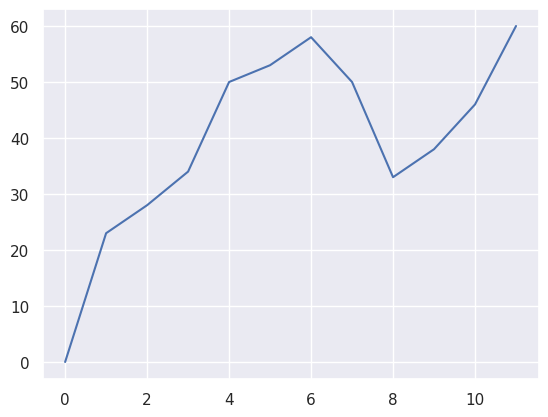

In [30]:
from matplotlib import pyplot as plt
import seaborn as sns

sns.set_theme()
plt.plot(n_edge_m2a)

In [33]:
mask_logits_dict_weight = torch.load(
    join(mask_dir, f'mask_logits_dict_weight_oqa_weight_114_edge_0.pt')
)
mask_logits_dict_weight = {
    k:v.detach().cpu() for k,v in mask_logits_dict_weight.items()
}

torch.cuda.empty_cache()

In [36]:
mask_logits_dict_weight.keys()

dict_keys(['blocks.0.attn.W_Q', 'blocks.0.attn.b_Q', 'blocks.0.attn.W_K', 'blocks.0.attn.b_K', 'blocks.0.attn.W_V', 'blocks.0.attn.b_V', 'blocks.0.attn.W_O', 'blocks.0.attn.b_O', 'blocks.0.mlp.W_in', 'blocks.0.mlp.b_in', 'blocks.0.mlp.W_out', 'blocks.0.mlp.b_out', 'blocks.1.attn.W_Q', 'blocks.1.attn.b_Q', 'blocks.1.attn.W_K', 'blocks.1.attn.b_K', 'blocks.1.attn.W_V', 'blocks.1.attn.b_V', 'blocks.1.attn.W_O', 'blocks.1.attn.b_O', 'blocks.1.mlp.W_in', 'blocks.1.mlp.b_in', 'blocks.1.mlp.W_out', 'blocks.1.mlp.b_out', 'blocks.2.attn.W_Q', 'blocks.2.attn.b_Q', 'blocks.2.attn.W_K', 'blocks.2.attn.b_K', 'blocks.2.attn.W_V', 'blocks.2.attn.b_V', 'blocks.2.attn.W_O', 'blocks.2.attn.b_O', 'blocks.2.mlp.W_in', 'blocks.2.mlp.b_in', 'blocks.2.mlp.W_out', 'blocks.2.mlp.b_out', 'blocks.3.attn.W_Q', 'blocks.3.attn.b_Q', 'blocks.3.attn.W_K', 'blocks.3.attn.b_K', 'blocks.3.attn.W_V', 'blocks.3.attn.b_V', 'blocks.3.attn.W_O', 'blocks.3.attn.b_O', 'blocks.3.mlp.W_in', 'blocks.3.mlp.b_in', 'blocks.3.mlp.W_o

In [42]:
mlp_n_params_total = [0 for i in range(12)]
attn_n_params_total = [0 for i in range(12)]

mlp_n_params_circuit = [0 for i in range(12)]
attn_n_params_circuit = [0 for i in range(12)]

for module_name, mask_logits in mask_logits_dict_weight.items():
    l = int(module_name.split('.')[1])
    if 'mlp' in module_name:
        mlp_n_params_total[l] += torch.ones_like(mask_logits).sum()
        mlp_n_params_circuit[l] += torch.where(mask_logits > 0., 1., 0.).sum()
    if 'attn' in module_name:
        attn_n_params_total[l] += torch.ones_like(mask_logits).sum()
        attn_n_params_circuit[l] += torch.where(mask_logits > 0., 1., 0.).sum()

In [44]:
mlp_dens = torch.stack(mlp_n_params_circuit) / mlp_n_params_total[0]
attn_dens = torch.stack(attn_n_params_circuit) / attn_n_params_total[0]

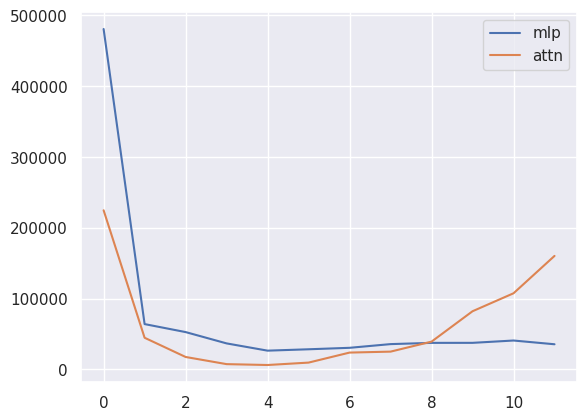

In [59]:
plt.plot(mlp_n_params_circuit, 1, label='mlp')
plt.plot(attn_n_params_circuit, 1, label='attn')

# plt.plot(mlp_n_params_circuit[1:], label='mlp')
# plt.plot(attn_n_params_circuit[1:], label='attn')

plt.legend()